<a href="https://colab.research.google.com/github/Karenjbc7/T-picos/blob/main/Bono_Primer_Parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se carga la base de datos que se va a usar.

In [ ]:
from google.colab import files # Para cargar archivos en google colab
uploaded = files.upload()

Saving serie_completa (1).csv to serie_completa (1) (2).csv


Se carga y se transforma el archivo CSV mediante la funcion read_csv de pandas.

En la línea 4, se especifica que las columnas estan separadas por comas y además, la codificación, pues se está trabajando con datos en español que puede contener caracteres especiales.
En la línea 5, se muestran las 4 primeras filas .head(4) para verificar la carga.


In [ ]:
import pandas as pd
import io
serie_covid1 = io.BytesIO(uploaded['serie_completa (1) (2).csv'])
serie_covid = pd.read_csv(serie_covid1, sep = ",", encoding="latin-1")
serie_covid.head(4)

,Fecha,Frecuencia
0,2020-02-27,1
1,2020-02-28,2
2,2020-02-29,2
3,2020-03-01,4


Se muestran las 4 últimas filas .tail(4) para verificar la carga.



In [ ]:
serie_covid.tail(4)

,Fecha,Frecuencia
1415,2024-01-12,53
1416,2024-01-13,21
1417,2024-01-14,9
1418,2024-01-15,1


Se normalizan los datos con MinMaxScaler para mejorar la convergencia.
Se convierte la columna 'Fecha' a formato datetime, agrupando por periodos.

En el gráfico se observa que, inicialmente hay un crecimiento exponencial, luego unos picos consistentes con alta variabilidad, para finalmente estabilizarse a partir del 2023.

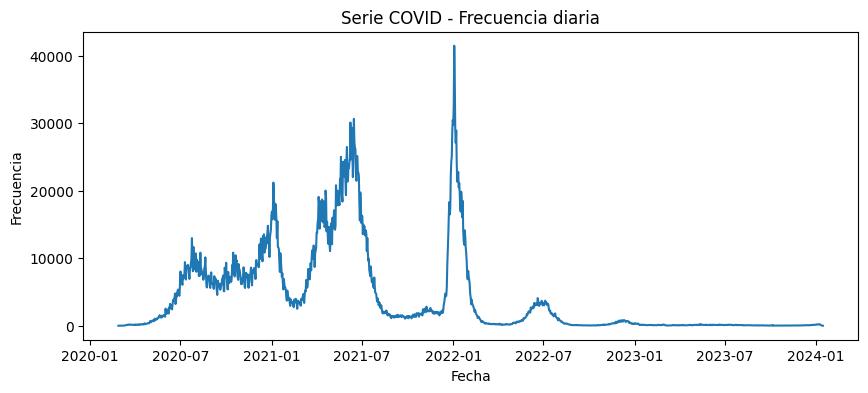

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

serie_covid['Fecha'] = pd.to_datetime(serie_covid['Fecha'])
serie_covid = serie_covid.sort_values('Fecha').reset_index(drop=True) # Ordenar por fecha por si acaso
plt.figure(figsize=(10,4))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'])
plt.title('Serie COVID - Frecuencia diaria')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.show()

Como los datos tienen valores que pueden oscilar entre cientos y decenas de miles , por lo que se realiza la normalización de estos, esto reduce la complejidad de los parámetros en LSTM.

In [ ]:
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie_covid['Frecuencia'].values.reshape(-1, 1)) # Acá se hace un escalamiento de los datos
serie_scaled

array([[0.00000000e+00],
       [2.41062604e-05],
       [2.41062604e-05],
       ...,
       [4.82125208e-04],
       [1.92850083e-04],
       [0.00000000e+00]])

Se crean ventanas temporales para transformar la serie temporal en un problema de aprendizaje supervisado, donde cada muestra consiste en:
- Entrada (X): una secuencia de 'pasos' valores consecutivos
- Salida (y): el valor inmediatamente siguiente a la secuencia de entrada

In [ ]:
def crear_secuencias(data, pasos): # Para crear ventanas temporales
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i + pasos])
        y.append(data[i + pasos])
    return np.array(X), np.array(y)
# data = [10, 20, 30, 40, 50, 60, 70], pasos = 3 (ventana de 3 días). Los bucles generados sera así [10, 20, 30]

pasos = 30 # Tamaño de ventana temporal (por ejemplo 30 días)
X, y = crear_secuencias(serie_scaled, pasos)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# X.shape = (1389, 30, 1) Hay 1389 datos, cada uno con de 30 filas y 1 columna

X.shape = (1389, 30, 1), y.shape = (1389, 1)


Se realiza una división temporal de los datos entre:
- Datos de entrenamiento 80%, que corresponden a los primeros datos obtenidos (1
-1111 día).
- Los datos de validación 20%, que son los más recientes (a partir 1112 día hasta el último).

In [ ]:
train_size = int(len(X) * 0.8) # División del conjunto de datos
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

print("X_train:", X_train.shape, ", Tamaño entrenamiento: {len(X_train)}")
print("y_train:", y_train.shape, ", Tamaño validación: {len(X_val)}")


X_train: (1111, 30, 1) , Tamaño entrenamiento: {len(X_train)}
y_train: (1111, 1) , Tamaño validación: {len(X_val)}


Visualización de los datos de entrenamiento y de validación.
La línea roja es el punto de corte en la divisón temporal.

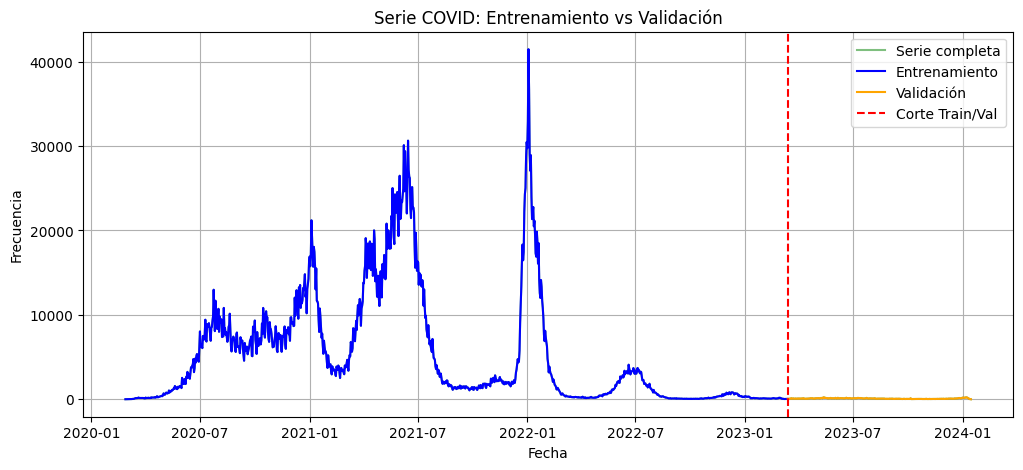

In [ ]:
fecha_entrenamiento = serie_covid['Fecha'][:train_size]
fecha_validacion = serie_covid['Fecha'][train_size:]

plt.figure(figsize=(12,5))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], color='green', alpha=0.5, label='Serie completa')

plt.plot(fecha_entrenamiento, serie_covid['Frecuencia'][:train_size], color='blue', label='Entrenamiento')
plt.plot(fecha_validacion, serie_covid['Frecuencia'][train_size:], color='orange', label='Validación')

# Líneas divisorias
plt.axvline(x=serie_covid['Fecha'].iloc[train_size], color='red', linestyle='--', label='Corte Train/Val')

plt.title('Serie COVID: Entrenamiento vs Validación')
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True)
plt.show()

El modelo va a predecir un solo valor por cada secuencia de entrada, y na, indica que tiene 200 capas ocultas.

In [ ]:
dim_entrada = (X_train.shape[1],1) # Cada entrada es una secuencia de 30 pasos temporales, con una sola característica por paso temporal.
dim_salida = 1 # El modelo debe predecir un solo valor (por ejemplo, el siguiente valor en la secuencia).
na = 200 # La red tendrá una capa oculta con na neuronas, lo que afecta su capacidad de aprendizaje.

Implementación del LSTM:

Input(shape=(X_train.shape[1], X_train.shape[2])): Define la forma de entrada: (timesteps=30, features=1)
   - Timesteps: número de pasos temporales en cada secuencia (ventana de 30 días)
   - Features: número de características por timestep (1: frecuencia de casos)
   - Esta capa no tiene parámetros, solo especifica la forma de los datos.

Primera Capa: LSTM(24, return_sequences=True),  el número de parámetros está dado por: 4*(n²+n*m+n) = 4*(24²+24*1+24) = 2,496 parámetros. Aprende patrones locales.

Dropout(0.3): desactiva el 30% de las conexiones. Srivastava et al. (2014) demostró que dropout reduce el overfitting significativamente.

Segunda capa: 32 unidades. Parámetros: 4 * (32² + 32*24 + 32) = 7,296 parámetros. Aprende representaciones más abstractas.

Capa Intermedia Dense(30, activation='relu'), usar la función RElu es computacionalmente eficiente. Aprende transformaciones no lineales antes de la prediccion final.

CApa de salida: Dense(1, activation='linear').



In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

modelo = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(30, activation='relu'),
    Dense(1, activation='linear')
])

modelo.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')
modelo.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 30)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,813 (42.24 KB)

 Trainable params: 10,813 (42.24 KB)

 Non-trainable params: 0 (0.00 B)

EarlyStopping es una técnica de regularización que previene overfitting en el proceso de entrenamiento.

val_loss: Observa la pérdida en el conjunto de validación (no en entrenamiento), es calculada al final de cada época sobre datos no vistos durante el entrenamiento.

patience=10, es el número de épocas sin mejora antes de detener el entrenamiento. Si es menor a 5, puede detener prematuramente si hay ruido en el val_loss. Si es mayor a 50, puede permitir overfitting. Si el val_loss no mejora en 10 épocas, probablemte el modelo ha alcanzado su capacidad óptima o puede que esté empezando a sobreajustarse.

Los parámetros de entrenamiento:

Epochs= 300: numero máximo de iteraciones completas sobre el conjunto de entrenamiento, debe ser alto para permitir convergencia.

batch_size=32: numero de muestras procesadas antes de actualizar los pesos. se recomienda usar entre 32-64.

validation_data=(X_val, y_val): conjunto de datos usado para evaluar el modelo durante entrenamiento.

callbacks=[early_stop]: ejecuta al final del entrenamiento.

verbose=1: controla la cantidad de informaciónm mostrada durante el entrenamiento.


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = modelo.fit(
    X_train, y_train,
    epochs=300,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0296 - val_loss: 0.0026
Epoch 2/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0135 - val_loss: 0.0053
Epoch 3/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0077 - val_loss: 0.0021
Epoch 4/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0054 - val_loss: 5.9039e-04
Epoch 5/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0050 - val_loss: 3.6219e-04
Epoch 6/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0052 - val_loss: 1.2455e-04
Epoch 7/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0047 - val_loss: 1.6065e-04
Epoch 8/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0048 - val_loss: 3.4230e-05
Epoch 9/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0044 - val_loss: 7.8100e-05
Epoch 10/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0039 - val_loss: 9.8603e-05
Epoch 11/300
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0033 - val_loss: 1.2769e-04
Epoch 12/300
35/35 ━

Historial del entrenamiento para encontrar la mejor época con mejor rendimiento en validación.

val_loss contiene los valores de perdida de validación por época.

train_loss contiene los valores de perdida de entrenamiento por época.

best_epoch devuelve la época con menor val_loss


In [ ]:
val_loss = np.array(hist.history['val_loss'])
train_loss = np.array(hist.history['loss'])
best_epoch = np.argmin(val_loss)
print(f"Mejor época (mínimo val_loss): {best_epoch+1} (0-based index {best_epoch})")
print(f"val_loss_min = {val_loss[best_epoch]:.6e}, train_loss en esa época = {train_loss[best_epoch]:.6e}")

Mejor época (mínimo val_loss): 26 (0-based index 25)
val_loss_min = 4.666983e-07, train_loss en esa época = 2.042538e-03


Entrena el modelo hasta la mejor época

In [ ]:
modelo.fit(X_train,y_train, epochs= best_epoch, batch_size=32) # Entrenamiento

Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0019
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0020
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0016
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0017
Epoch 10/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0020
Epoch 11/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0019
Epoch 12/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0018
Epoch 13/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0016
Epoch 14/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 15/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0015
Epoc

REpresentacion de la curva que muestra la evolucion del Error Cuadrático Medio (MSE) en el conjunto de validación a lo largo de las épocas. Tener más épocas no garantiza necesariamente mayor convergencia edl metodo de estimacion. Esto sugiere que se debe encontrar el punto óptimo de detencion antes de que comience el overfitting.

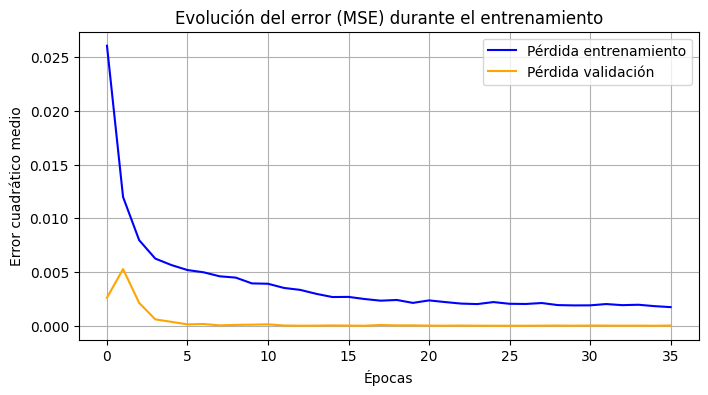

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], label='Pérdida entrenamiento', color='blue')
plt.plot(hist.history['val_loss'], label='Pérdida validación', color='orange')
plt.title('Evolución del error (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Error cuadrático medio')
plt.legend()
plt.grid(True)
plt.show()

Este gráfico compara los valores reales con los predichos del modelo. Se desescalan las predicciones a su escala original.

La línea de predicciones está siguiendo la líea de valores reales, incluso en algunos picos, capturando la variabilidad.

En la tabla se observa que hay sobreestimación.

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


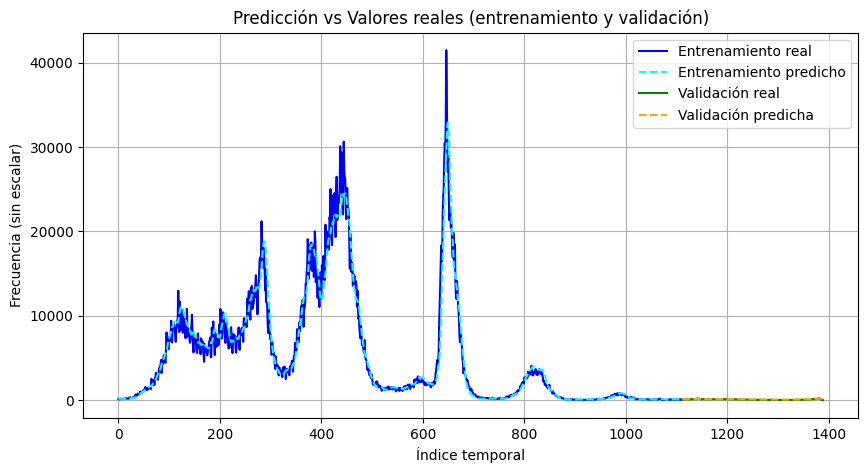

    Real    Predicho
0   62.0  105.945290
1   50.0  104.502983
2   78.0  101.764786
3   65.0   99.917206
4   81.0   98.074234
5   84.0   97.251411
6   78.0   97.373390
7   96.0   97.749611
8  122.0   99.340263
9  104.0  103.083366


In [ ]:
pred_train = modelo.predict(X_train)
pred_val = modelo.predict(X_val)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1)) # Desescala tanto el entrenamiento como la validación
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
pred_train_inv = scaler.inverse_transform(pred_train)
pred_val_inv = scaler.inverse_transform(pred_val)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Entrenamiento real', color='blue')
plt.plot(np.arange(len(y_train_inv)), pred_train_inv, label='Entrenamiento predicho', color='cyan', linestyle='--')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), y_val_inv, label='Validación real', color='green')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_val_inv)), pred_val_inv, label='Validación predicha', color='orange', linestyle='--')
plt.title('Predicción vs Valores reales (entrenamiento y validación)')
plt.xlabel('Índice temporal')
plt.ylabel('Frecuencia (sin escalar)')
plt.legend()
plt.grid(True)
plt.show()

# --- Comparación en tabla ---
comparacion = pd.DataFrame({
    'Real': y_val_inv.flatten(),
    'Predicho': pred_val_inv.flatten()
})
print(comparacion.head(10))

El coeficiente de determinación del modelo LSTM (R² = 0.273) no capta suficiente variabilidad. Como RMSE > MAE, indica presencia de errores uniformes. Se puede usar el modelo GRU para comparar.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv)))
print(" R2:", r2_score(y_val_inv, pred_val_inv))


Evaluación en validación:
 MAE: 32.331640614022454
 RMSE: 39.062006031482895
 R2: 0.27317438394245797


In [ ]:
ventana = 30  # o el número de pasos que usaste al crear las secuencias
ultimos_datos_scaled = serie_scaled[-ventana:]  # últimos 30 valores de la serie escalada
ultimos_datos_scaled = ultimos_datos_scaled.reshape(1, ventana, 1)  # formato 3D (batch, timesteps, features)
print(ultimos_datos_scaled.shape)

(1, 30, 1)


Se realiza la prediccion multipaso hacia adelante en series temporales, esta es la predicción de períodos futuros no observados, objetivo final del modelo.

In [ ]:
n_pred = 15  # número de días a predecir
ventana = 30  # mismo tamaño de ventana
X_pred = ultimos_datos_scaled.copy()
predicciones_futuras = []

for _ in range(n_pred):
    pred = modelo.predict(X_pred, verbose=0)  # pred.shape = (1, 1)
    predicciones_futuras.append(pred[0, 0])
    nuevo_valor = np.reshape(pred, (1, 1, 1)) # Convertir la predicción en la misma forma (1, 1, 1)
    X_pred = np.concatenate([X_pred[:, 1:, :], nuevo_valor], axis=1) # Concatenar correctamente (manteniendo las 3 dimensiones)

# Convertir a array y desescalar
predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)


Se eligen 80 días como horizonte de presicción, es un periodo suficiente para evaluar tendencias.

Según el gráfico, la predicción muestra estabilizacion, no hay picos ni rebotes.

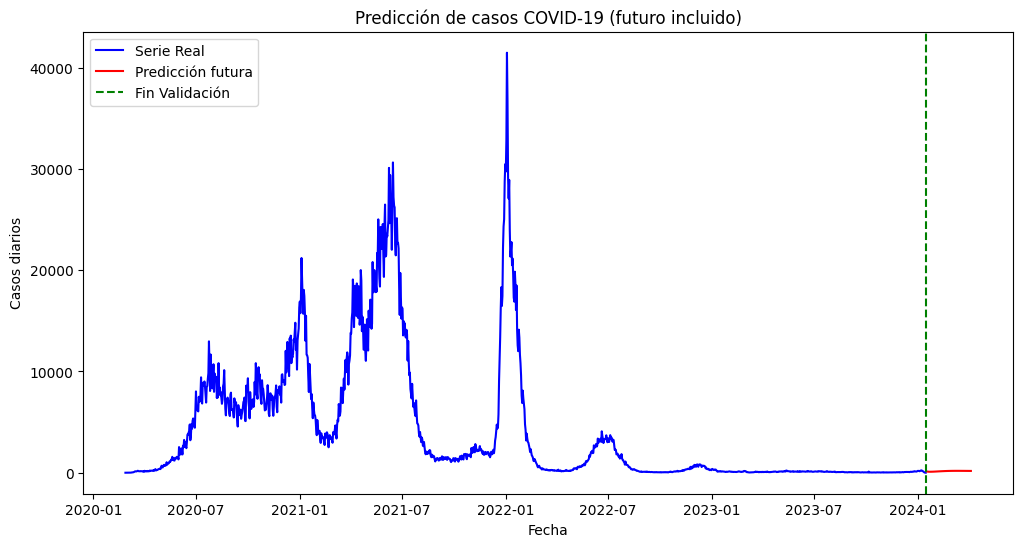

In [ ]:
n_futuro = 80

ult_fecha = serie_covid['Fecha'].max() # 2. Crear fechas futuras
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2]) # 3. Predicción futura
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    # Redimensionar pred a (1,1,1) para concatenar correctamente
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1) # 4. Inversa de escalado
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

plt.figure(figsize=(12, 6)) # 5. Gráfico
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')

plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido)')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

Implementación del modelo GRU: Las GRU fueron propuestas por Cho et al. (2014) como una simplificación de las LSTM que mantiene su capacidad de capturar dependencias a largo plazo pero con una arquitectura más eficiente.

GRU: Tiene 3 parámetros, es 25% más eficiente.

La primera capa tienen 128 unidades, segunda capa 64 unidades. Una capa de salida sin capa intermedia.


In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

modelo1 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dense(1)
])

modelo1.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

Se aplica EarlyStopping con patience =100.

Al ser un modelo más complejo necesita más épocas, presenta fluctuaciones grandes y valores de pérdida muy pequeños.

Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0279 - val_loss: 5.1286e-04
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0024 - val_loss: 5.1999e-05
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0015 - val_loss: 1.4406e-05
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - loss: 0.0014 - val_loss: 1.4226e-05
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0016 - val_loss: 1.1422e-05
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0013 - val_loss: 3.0791e-06
Epoch 7/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0013 - val_loss: 3.2220e-07
Epoch 8/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0013 - val_loss: 7.8782e-05
Epoch 9/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0011 - val_loss: 7.9247e-06
Epoch 10/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0012 - val_loss: 3.4501e-07
Epoch 11/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0010 - val_loss: 1.6057e-05
Epoc

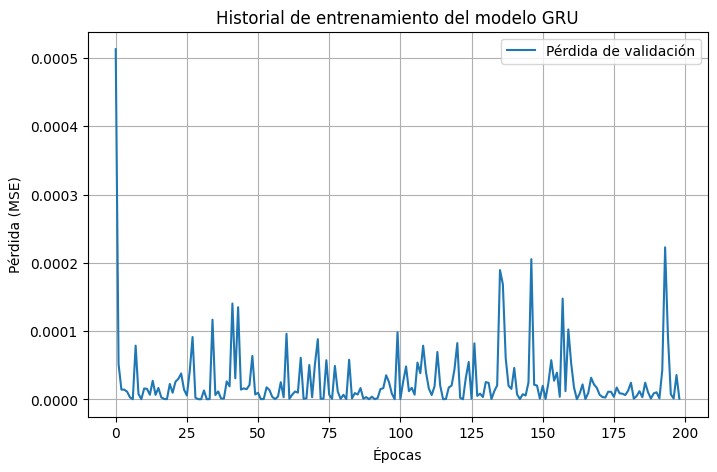

In [ ]:
early_stop1 = EarlyStopping(
    monitor='val_loss',       # Métrica de validación a vigilar
    patience=100,              # Detener si no mejora en 10 épocas
    restore_best_weights=True # Restaurar los mejores pesos
)

# ====== Entrenamiento ======
hist1 = modelo1.fit(
    X_train, y_train,
    epochs=400,
    batch_size=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop1],
    verbose=1
)

# ====== Gráfico del historial ======
plt.figure(figsize=(8,5))
# plt.plot(hist1.history['loss'], label='Pérdida de entrenamiento')
plt.plot(hist1.history['val_loss'], label='Pérdida de validación')
plt.title('Historial de entrenamiento del modelo GRU')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pred_train1 = modelo1.predict(X_train)
pred_val1 = modelo1.predict(X_val)

pred_train_inv1 = scaler.inverse_transform(pred_train1)
pred_val_inv1 = scaler.inverse_transform(pred_val1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


El modelo explica el 77% de la varianza, es un modelo útil con mejor ajuste, en comparación con el LSTM.

In [ ]:
print("\nEvaluación en validación:")
print(" MAE:", mean_absolute_error(y_val_inv, pred_val_inv1))
print(" RMSE:", np.sqrt(mean_squared_error(y_val_inv, pred_val_inv1)))
print(" R2:", r2_score(y_val_inv, pred_val_inv1))


Evaluación en validación:
 MAE: 15.937324455316118
 RMSE: 22.069760880624244
 R2: 0.7679848228013568


El modelo puede tener excelentes métricas pero generar predicciones a futuro qoe son imposibles. El modelo aprende patrones estadísticos, pero no incorpora restricciones de dominio, no "entiende" que casos de enfermedad no pueden ser negativos.

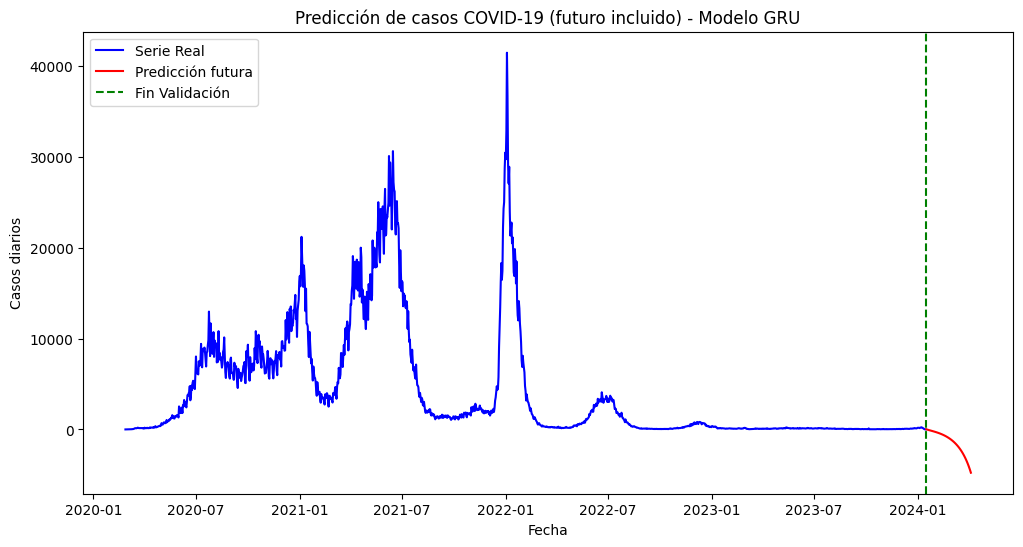

In [ ]:
fechas_futuras = pd.date_range(start=ult_fecha + pd.Timedelta(days=1), periods=n_futuro, freq='D')

X_pred = X_val[-1].reshape(1, X_val.shape[1], X_val.shape[2])
predicciones_futuras = []

for _ in range(n_futuro):
    pred = modelo1.predict(X_pred, verbose=0)
    predicciones_futuras.append(pred[0, 0])
    pred_reshaped = pred.reshape(1, 1, 1)
    X_pred = np.concatenate((X_pred[:, 1:, :], pred_reshaped), axis=1)

predicciones_futuras = np.array(predicciones_futuras).reshape(-1, 1)
predicciones_futuras_inv = scaler.inverse_transform(predicciones_futuras)

# 7. Gráfico general
plt.figure(figsize=(12, 6))
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')
plt.plot(fechas_futuras, predicciones_futuras_inv, label='Predicción futura', color='red', linestyle='-')
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')
plt.title('Predicción de casos COVID-19 (futuro incluido) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.show()

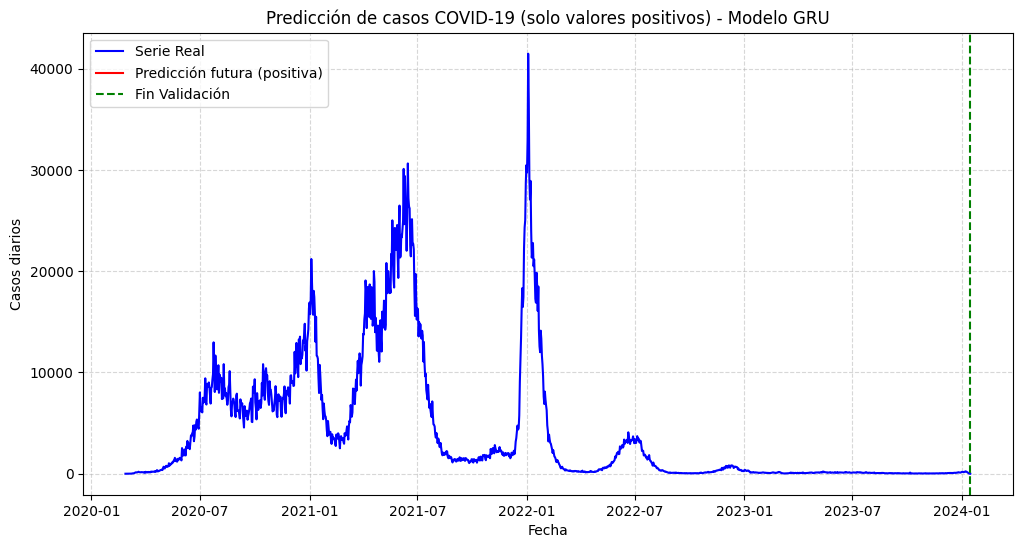

In [ ]:
predicciones_futuras_pos = np.ravel(np.array(predicciones_futuras_inv))
fechas_futuras_pos = np.array(fechas_futuras)

# Crear máscara para valores positivos
mask_pos = predicciones_futuras_pos > 0

# Aplicar la máscara
predicciones_futuras_pos = predicciones_futuras_pos[mask_pos]
fechas_futuras_pos = fechas_futuras_pos[mask_pos]

# --- 7. Gráfico general ---
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(serie_covid['Fecha'], serie_covid['Frecuencia'], label='Serie Real', color='blue')

# Predicción futura (solo positivas)
plt.plot(fechas_futuras_pos, predicciones_futuras_pos, label='Predicción futura (positiva)', color='red', linestyle='-')

# Línea vertical del fin de validación
plt.axvline(x=ult_fecha, color='green', linestyle='--', label='Fin Validación')

plt.title('Predicción de casos COVID-19 (solo valores positivos) - Modelo GRU')
plt.xlabel('Fecha')
plt.ylabel('Casos diarios')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

**Conclusiones**

Los resultados deben cumplir propiedades estadísticas:

1. Varianzas positivas.
2. Coeficiente de determinacion en [0,1].
Pero además, los resultados deben tener sentido en el contexto.

Según reportes del Ministerio de Salud, el COVID-19 en Colombia tuvo el siguiente desarrollo:
- Transición hacia estado endémico
- Reducción de riesgo pandémico
- Estabilización en niveles bajos